In [1]:
import numpy as np
import numpy.random as npr
import scipy.sparse as sp
import networkx as nx
import networkx.algorithms.bipartite as bpt
import matplotlib.pyplot as plt
import pym4ri

In [2]:
# Configure Matplotlib fonts to match IEEE template
plt.rcParams['font.family'] = 'serif'  # Set the main font family to serif
plt.rcParams['font.monospace'] = ['Courier']  # Use Courier for monospaced text
plt.rcParams['font.serif'] = ['Computer Modern', 'DejaVu Serif', 'Liberation Serif', 'Nimbus Roman']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Liberation Sans', 'Nimbus Sans']
plt.rc('text', usetex=True)

## Utils

In [3]:
def load_tanner_graph(filename):
    m, n = np.loadtxt(filename, max_rows=1, dtype=int)
    indices, indptr = np.array([], dtype=int), [0]
    for r in range(m):
        r_ind = np.loadtxt(filename, skiprows=r+1, max_rows=1, dtype=int)
        indices = np.concatenate([indices, np.sort(r_ind)])
        indptr.append(len(r_ind))
    
    H = sp.csr_array((m, n), dtype=int)
    H.data = np.ones_like(indices, dtype=int)
    H.indices = indices
    H.indptr = np.cumsum(indptr)

    return bpt.from_biadjacency_matrix(H, create_using=nx.MultiGraph)

def graph_transpose(G: nx.Graph) -> nx.Graph:
    a = [n for n, b in G.nodes(data='bipartite') if b == 0]
    return bpt.from_biadjacency_matrix(bpt.biadjacency_matrix(G, row_order=a).T, create_using=nx.Graph)

In [4]:
def draw_bpt_graph(G: nx.MultiGraph, ax=None, highlight_edges=None, no_parse=False):
    checks = [n for n, b in G.nodes(data='bipartite') if b == 0]
    bits = [n for n, b in G.nodes(data='bipartite') if b == 1]
    pos = nx.layout.bipartite_layout(G, bits)

    parse_labels = lambda n: '$c_{%}$'.replace('%', str(n+1)) if n in checks else '$b_{%}$'.replace('%', str(n+1-len(checks)))
    if no_parse:
        parse_labels = lambda n: n

    colors = {n: i%10 for i, n in enumerate(checks)}
    
    # Draw the graph
    if ax is None:
        plt.figure(figsize=(5, 4))
        
    if highlight_edges is None:
        nx.draw_networkx_nodes(G, pos, ax=ax, alpha=0.7, nodelist=checks, node_color='grey', node_shape='s', node_size=400)
        nx.draw_networkx_nodes(G, pos, ax=ax, alpha=0.7, nodelist=bits, node_color='purple', node_shape='o', node_size=400)
        nx.draw_networkx_labels(G, pos, ax=ax,
                                labels={n: parse_labels(n) for n in G.nodes})
        nx.draw_networkx_edges(G, pos, ax=ax,
                edge_color=[colors[u] for (u, *_) in G.edges(data=False)], 
                edge_cmap=plt.cm.tab10, edge_vmin=0, edge_vmax=9)
    else:
        nx.draw_networkx_nodes(G, pos, ax=ax, alpha=0.7,
                               node_color=['grey' if n in checks else 'purple' for n in G.nodes])
        nx.draw_networkx_labels(G, pos, ax=ax,
                                labels={n: parse_labels(n) for n in G.nodes})
        nx.draw_networkx_edges(G, pos, ax=ax,
                edge_color=[colors[u] for (u, *_) in G.edges(data=False)], 
                edge_cmap=plt.cm.tab10, edge_vmin=0, edge_vmax=9, alpha=0.5, width=1)
        nx.draw_networkx_edges(G, pos, edgelist=highlight_edges, ax=ax, width=4, edge_color='crimson')
        nx.draw_networkx_edges(G, pos, edgelist=highlight_edges, ax=ax, width=2, edge_color='gold')
        nx.draw_networkx_edges(G, pos, edgelist=highlight_edges, ax=ax, width=0.5, edge_color='ivory')

        
    if ax is None:
        plt.show()

def split_linear_bpt_layout(G: nx.graph, flip: bool=False) -> dict[int: float]:
    l, h = -1, 1
    box = (h-l)/G.number_of_nodes()
    if flip:
        c = [n for n, b in G.nodes(data='bipartite') if b == 0]
        v = [n for n, b in G.nodes(data='bipartite') if b == 1]
        flip_c = lambda n: len(c)-1 - n
        flip_v = lambda n: len(v)-1 - (n - len(c)) + len(c)
        return {n: flip_c(n)*box + box/4 if b == 0 else flip_v(n)*box + box*3/4 for n, b in G.nodes(data='bipartite')}
    else:
        return {n: n*box + box/4 if b == 0 else n*box + box*3/4 for n, b in G.nodes(data='bipartite')}
    
def hgp_layout(G1: nx.Graph, G2: nx.Graph) -> dict[int: float]:
    # Assume G1 = (C1 u V1, E1), G2 = (C2 u V2, E2)
    # Display H = HGP(G1, G2) as
    # C1xC2 V1xC2
    # C1xV2 V1xV2
    h_layout = split_linear_bpt_layout(G1)
    v_layout = split_linear_bpt_layout(G2, flip=False)
    
    return {(n1, n2): np.array([h_layout[n1]-1, 1-v_layout[n2]]) \
            for n1 in G1.nodes for n2 in G2.nodes}

def draw_hgp_graph(G: nx.Graph, nodesize:int=500, fontsize:int=8, ax=None):
    # Gt = graph_transpose(G)
    c = [n for n, b in G.nodes(data='bipartite') if b == 0]
    v = [n for n, b in G.nodes(data='bipartite') if b == 1]
    # vt = [n for n, b in Gt.nodes(data='bipartite') if b == 0]
    # ct = [n for n, b in Gt.nodes(data='bipartite') if b == 1]
    
    HGP = nx.cartesian_product(G, G)
    
    X_pos, X_neg, Z_pos, Z_neg = [], [], [], []
    
    for (x1, y1), (x2, y2) in HGP.edges(data=False):
        if y1 == y2 and y1 in c:
            Z_neg.append(((x1, y1), (x2, y2)))
        if x1 == x2 and x1 in c:
            X_neg.append(((x1, y1), (x2, y2)))
        if x1 == x2 and x1 in v:
            Z_pos.append(((x1, y1), (x2, y2)))
        if y1 == y2 and y1 in v:
            X_pos.append(((x1, y1), (x2, y2)))
    
    V, C = bpt.sets(HGP)
    V = [n for n, b in HGP.nodes(data='bipartite') if b[0] == b[1]]
    C = [n for n, b in HGP.nodes(data='bipartite') if b[0] != b[1]]
    pos = hgp_layout(G, G)
    
    if ax is None:
        plt.figure(figsize=(8,8))
        
    nx.draw_networkx_edges(HGP, pos, edgelist=X_pos, arrows=True, ax=ax,
                           connectionstyle='arc3,rad=+0.3', edge_color='b')
    nx.draw_networkx_edges(HGP, pos, edgelist=Z_pos, arrows=True, ax=ax, 
                           connectionstyle='arc3,rad=-0.3', edge_color='r')
    nx.draw_networkx_edges(HGP, pos, edgelist=Z_neg, arrows=True, ax=ax, 
                           connectionstyle='arc3,rad=-0.3', edge_color='r')
    nx.draw_networkx_edges(HGP, pos, edgelist=X_neg, arrows=True, ax=ax, 
                           connectionstyle='arc3,rad=+0.3', edge_color='b')
    nx.draw_networkx_nodes(HGP, pos, nodelist=C, node_color='grey', 
                           node_shape='s', node_size=nodesize, ax=ax)
    nx.draw_networkx_nodes(HGP, pos, nodelist=V, node_color='purple', 
                           node_shape='o', node_size=nodesize, ax=ax)
    
    # parse_label = lambda nn: ('$c_{%} '.replace('%', str(1+nn[1])) if nn[1] in c else \
    #            '$v_{%} '.replace('%', str(1+nn[1] - len(c)))) + (
    #             'c_{%}$'.replace('%', str(1+nn[0])) if nn[0] in c else \
    #            'v_{%}$'.replace('%', str(1+nn[0] - len(c))))
    parse_label = lambda nn: nn
    
    nx.draw_networkx_labels(HGP, pos, labels={nn: parse_label(nn) for nn in HGP.nodes}, 
                           font_size=fontsize, ax=ax)
    if ax is None:
        plt.annotate('$X$', (-1.25, -1.15), color='b', fontsize=24)
        plt.annotate('$Z$', (+1.1, +1.05), color='r', fontsize=24)
        plt.show()
    else:
        ax.annotate('$X$', (-1.25, -1.15), color='b', fontsize=24)
        ax.annotate('$Z$', (+1.1, +1.05), color='r', fontsize=24)


# Classical Peeling decoder

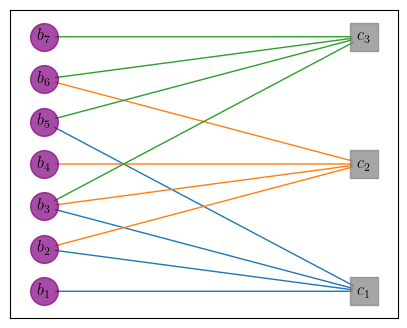

In [12]:
H_7_4_3 = sp.csr_array([
[1, 1, 1, 0, 1, 0, 0,],
[0, 1, 1, 1, 0, 1, 0,],
[0, 0, 1, 0, 1, 1, 1,],
])
G = bpt.from_biadjacency_matrix(H_7_4_3, create_using=nx.MultiGraph)
draw_bpt_graph(G)

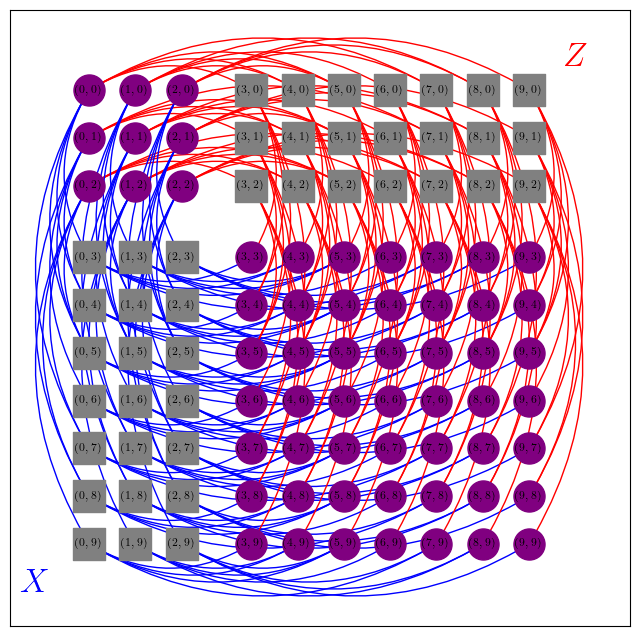

In [7]:
draw_hgp_graph(G)

In [227]:
def peel(erasure: np.array, H: sp.csr_array, show_ss=False, store_ss=False, viz=False, ax=None) -> tuple[bool, np.array]:
    SS = []
    while np.count_nonzero(erasure):
        if store_ss:
            SS.append(erasure.copy())
        erased_cols, *_ = np.where(erasure)
        H_E = H[:, erased_cols]

        if viz:
            print(erasure)
            G_E = bpt.from_biadjacency_matrix(H_E, create_using=nx.MultiGraph)
            nx.relabel_nodes(G_E, {i: f'$c_{{{i+1}}}$' for i in range(H.shape[0])}, copy=False)
            nx.relabel_nodes(G_E, {H.shape[0]+i: f'$b_{{{x+1}}}$' for i,x in enumerate(erased_cols)}, copy=False)
            draw_bpt_graph(G_E, no_parse=True, ax=ax)
            
        check_degrees = np.diff(H_E.indptr)
        dangling_checks, *_ = np.where(check_degrees == 1)
        if len(dangling_checks) > 0:
            dangling_check = npr.choice(dangling_checks)
            dangling_bit = erased_cols[H_E.indices[H_E.indptr[dangling_check]]]
            erasure[dangling_bit] = 0
        else:
            if store_ss:
                return False, np.row_stack(SS, dtype=np.uint8)
            return (False, set(erased_cols)) if show_ss else False
            # return (False, erasure) if show_ss else False
    return (True, set()) if show_ss else True
    # return (True, erasure) if show_ss else True

[ True False  True False False  True False]


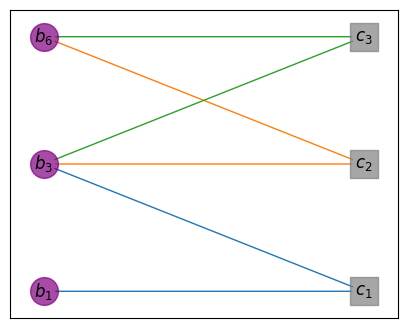

False

In [19]:
peel(npr.rand(7) < 0.5, H_7_4_3, viz=True)

In [20]:
def peeling_benchmark(erasure_rate: float, H: sp.csr_array, MC_budget: int=int(1e4)) -> tuple[float, float]:
    failures = 0
    N = H.shape[1]
    for _ in range(MC_budget):
        erasure = npr.rand(N) < erasure_rate
        if not peel(erasure, H):
            failures += 1

    return failures/MC_budget, ((failures*(MC_budget - failures)) / (MC_budget*(MC_budget - 1)))**.5

In [106]:
def erasure_failure_plot(erasure_rates, failure_rates, MC_budget, ax=None, label=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    
    ax.semilogy(erasure_rates, failure_rates['m'])
    ax.fill_between(erasure_rates, 
                     failure_rates['m'] + 1.96*failure_rates['s']/np.sqrt(MC_budget), 
                     failure_rates['m'] - 1.96*failure_rates['s']/np.sqrt(MC_budget), alpha=0.7, label=label)
    ax.set_xlabel(r'$\epsilon$')
    ax.set_ylabel(r'$P_L$')
    ax.grid('minor')
    ax.set_xlim([0, 0.35])


def peeling_MC_BM_plot(codes: list[sp.csr_array], erasure_rates:np.array, MC_budget:int, ax=None, labels=None):
    if type(codes) != list:
        codes = [codes]
    
    if labels is None:
        IT = zip(codes, [None]*len(codes))
    else:
        IT = zip(codes, labels)
    
    for H, lbl in IT:
        failure_rates = {'m': [], 's': []}
        
        for e_r in erasure_rates:
            mean, std = peeling_benchmark(e_r, H_7_4_3, MC_budget)
            failure_rates['m'].append(mean)
            failure_rates['s'].append(std)
        
        failure_rates['m'] = np.array(failure_rates['m'])
        failure_rates['s'] = np.array(failure_rates['s'])
    
        erasure_failure_plot(erasure_rates, failure_rates, MC_budget, ax=ax, label=lbl)
    
    if labels is not None:
        plt.legend()
    plt.show()


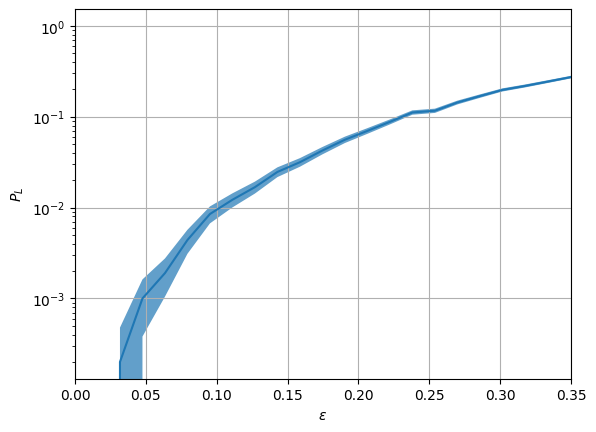

In [107]:
MC_budget = int(1e4)
erasure_rates = np.linspace(0., 1., 64)
peeling_MC_BM_plot(H_7_4_3, erasure_rates, MC_budget)

# Sampling from $\mathrm{LDPC}(\Lambda, P)$ ensembles

## TODO:
- find out how to expurge classical stopping sets;
- write a routine to sample from the LDPC ensembles;
- learn how to do pruning;
- run peeling on several codes and estimate the statistics of SS(k), i.e., the number of distinct stopping sets with exactly k degree-one check nodes. for small, classical codes, you can brute force and find all of them. for large HGP codes, run peeling several times and store the stopping sets classified by their number of degree-one check nodes (X errors only).
- compare peeling failure rate curves for the $\mathrm{LDPC}(\Lambda_X, P_X)$ ensemble vs. $\mathrm{HGP}(\mathrm{LDPC}(\Lambda, P))$. 

In [24]:
def sample_LDPC(Lbda: np.poly1d, P: np.poly1d) -> sp.csr_array:
    # Recall graph parameters
    n, m, E = Lbda(1), P(1), P.deriv()(1)
    assert Lbda.deriv()(1) == P.deriv()(1), "Number of edges is inconsistent: Lambda'(1) =/= P'(1)"
    
    # Fill in indptr for csr_array format
    indptr = np.zeros(m+1, dtype=np.int32)
    offset = 1
    for i, P_i in enumerate(P.c[::-1]):
        indptr[offset:offset+P_i] = i
        offset += P_i
    indptr = np.cumsum(indptr)

    # Fill in indices for csr_array format
    indices = np.zeros(E, dtype=np.int32)
    ind_offset, elem_offset = 0, 0
    for i, Lbda_i in enumerate(Lbda.c[::-1]):
        indices[ind_offset:ind_offset+i*Lbda_i] = elem_offset+np.arange(i*Lbda_i)//i
        elem_offset += Lbda_i
        ind_offset += i*Lbda_i
    
    # Apply random edge permutation
    indices = indices[npr.permutation(E)]
    
    # Create sparse biadjacency matrix
    H = sp.csr_array((np.ones(E, dtype=np.int32), indices, indptr), shape=(m, n))
    # Count multiple edges mod 2
    return sp.csr_array(H.todense()&1)


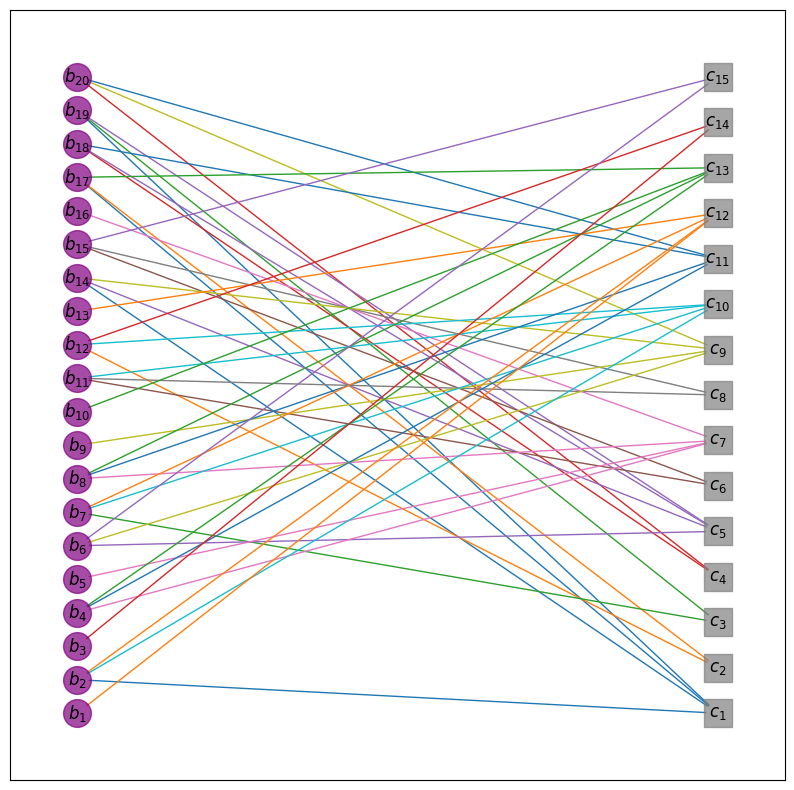

In [26]:
Lbda = np.poly1d([20, 0, 0, 0])
P = np.poly1d([15, 0, 0, 0, 0])

H = sample_LDPC(Lbda, P)

fig, ax = plt.subplots(1,1, figsize=(10,10))
draw_bpt_graph(bpt.from_biadjacency_matrix(H, create_using=nx.MultiGraph), ax=ax)

# Build HGP codes

In [13]:
def HGP(H1: sp.csr_array, H2: sp.csr_array=None):
    # Convention: H1 is the vertical axis, H2 is the horizontal axis
    # BB | BC (Z stab)
    # CB | CC
    # (X stab)
    if H2 is None:
        H2 = H1
    H1 = H1.astype(np.uint)
    H2 = H2.astype(np.uint)
    (m1, n1), (m2, n2) = H1.shape, H2.shape
    I = lambda n: sp.eye_array(n, dtype=np.uint)
    Hz = sp.hstack([sp.kron(I(n1), H2), sp.kron(H1.T, I(m2))]).asformat('csr')
    Hx = sp.hstack([sp.kron(H1, I(n2)), sp.kron(I(m1), H2.T)]).asformat('csr')
    return Hx, Hz

In [14]:
Hx, Hz = HGP(H_7_4_3)
((Hx @ Hz.T).todense() & 1).any()

False

# Compute code distances
- for small classical codes, brute force search over all the possible codewords
- maybe compute it for a few selected HGP codes. it is slightly more tricky and will take much longer

In [31]:
def brute_force_distance(H: sp.csr_array) -> int:
    # Get code parameters
    m, n = H.shape

    # Compute generator matrix and code dimension
    G = pym4ri.chk2gen(H.astype(bool).todense()).astype(np.uint)
    k = G.shape[1]

    # Sweep over all codewords and get the smallest weight
    d = np.inf
    for w in range(1, 1 << k):
        w_arr = np.array(list(np.binary_repr(w, width=k))).astype(np.uint)
        d = min(d, np.count_nonzero(G @ w_arr))

    return d
    

In [33]:
brute_force_distance(H_7_4_3)

3

# Compute $\mathrm{SS}(k)$

- $\mathrm{SS}(k)$ is the amount of erasure patterns where the number of degree-one check nodes is $k$
- for small classical codes, we can brute force it in $O(n 2^n)$. 

In [34]:
def brute_force_SS(H: sp.csr_array) -> np.array:
    # Get code parameters
    m, n = H.shape

    # Memory abusive approach: build a huge matrix n x 2^n with all erasure patterns
    patterns = np.column_stack([np.array(list(np.binary_repr(e, width=n)), dtype=np.uint) for e in range(1 << n)])

    # Count the amount of degree-one checks for each erasure pattern
    deg_one_checks = np.count_nonzero((H @ patterns) == 1, axis=0)
    
    return np.bincount(deg_one_checks, minlength=m+1)
    

In [35]:
H = sample_LDPC(np.poly1d([20, 0, 0, 0]), np.poly1d([15, 0, 0, 0, 0]))
# draw_bpt_graph(bpt.from_biadjacency_matrix(H, create_using=nx.MultiGraph))
m, n = H.shape
SSk_H = brute_force_SS(H) / (1 << n)
SSk_Ht = brute_force_SS(H.T) / (1 << m)

In [36]:
dist_H = brute_force_distance(H)
dist_Ht = brute_force_distance(H.T)

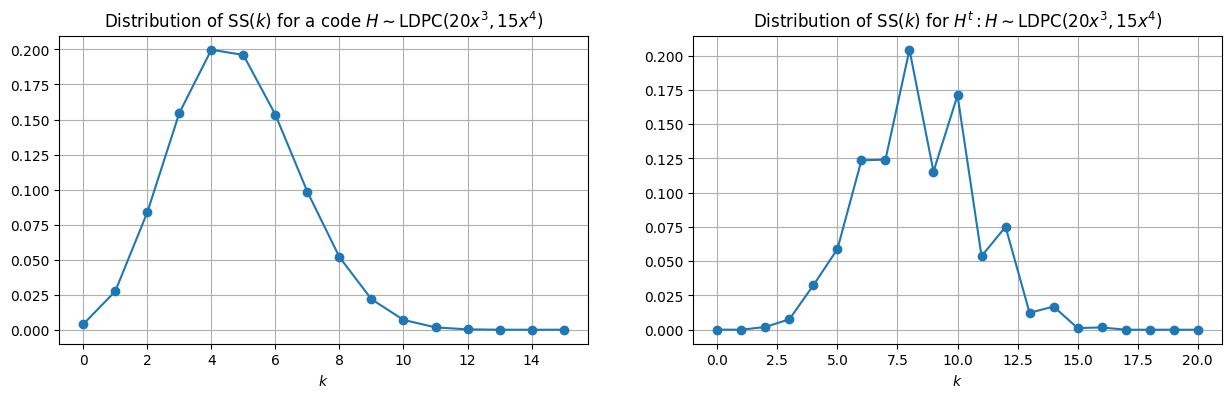

In [37]:
fig, (ax, axt) = plt.subplots(1, 2, figsize=(15,4))

ax.set_title(r'Distribution of $\mathrm{SS}(k)$ for a code $H \sim \mathrm{LDPC}(20 x^3, 15 x^4)$')
ax.plot(np.arange(m+1), SSk_H, 'o-')
ax.set_xlabel(r'$k$')
ax.grid('minor')

axt.set_title(r'Distribution of $\mathrm{SS}(k)$ for $H^t : H \sim \mathrm{LDPC}(20 x^3, 15 x^4)$')
mt, nt = n, m
axt.plot(np.arange(mt+1), SSk_Ht, 'o-')
axt.set_xlabel(r'$k$')
axt.grid('minor')

plt.show()

In [81]:
sample_H = lambda: sample_LDPC(np.poly1d([20, 0, 0, 0]), np.poly1d([15, 0, 0, 0, 0]))
# num_samples = 60

SSk_H_avg = np.mean(np.row_stack([brute_force_SS(sample_H()) for _ in range(num_samples)]), axis=0)/(1<<n)
SSk_Ht_avg = np.mean(np.row_stack([brute_force_SS(sample_H().T) for _ in range(num_samples)]), axis=0)/(1<<m)

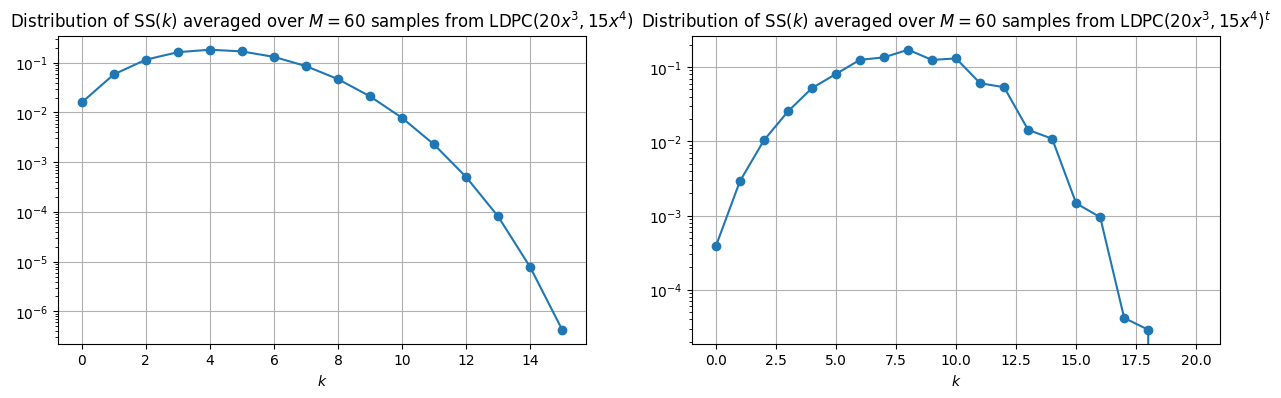

In [83]:
fig, (ax, axt) = plt.subplots(1, 2, figsize=(15,4))

ax.set_title(r'Distribution of $\mathrm{SS}(k)$ averaged over '+f'$M={num_samples}$'+r' samples from $\mathrm{LDPC}(20 x^3, 15 x^4)$')
ax.semilogy(np.arange(m+1), SSk_H_avg, 'o-')
ax.set_xlabel(r'$k$')
ax.grid('minor')

axt.set_title(r'Distribution of $\mathrm{SS}(k)$ averaged over '+f'$M={num_samples}$'+r' samples from $\mathrm{LDPC}(20 x^3, 15 x^4)^t$')
mt, nt = n, m
axt.semilogy(np.arange(mt+1), SSk_Ht_avg, 'o-')
axt.set_xlabel(r'$k$')
axt.grid('minor')

plt.show()

In [87]:
def brute_force_SS_k_vs_w(H: sp.csr_array) -> np.array:
    # Get code parameters
    m, n = H.shape

    # Memory abusive approach: build a huge matrix n x 2^n with all erasure patterns
    patterns = np.column_stack([np.array(list(np.binary_repr(e, width=n)), dtype=np.uint) for e in range(1 << n)])

    # Count the amount of degree-one checks for each erasure pattern and the pattern weights
    deg_one_checks = np.count_nonzero((H.astype(int) @ patterns) == 1, axis=0)
    pattern_weights = np.count_nonzero(patterns, axis=0)

    return sp.csr_array((np.ones(1<<n, dtype=np.uint), (deg_one_checks, pattern_weights)), shape=(m+1, n+1))
    

In [112]:
# sample_H = lambda: sample_LDPC(np.poly1d([20, 0, 0, 0]), np.poly1d([15, 0, 0, 0, 0]))
# H = sample_H()

def display_SSkxw(H: sp.csr_array, ks: list=[0, 1, 2]):
    m, n = H.shape
    SS_H_kxw = brute_force_SS_k_vs_w(H)
    SS_Ht_kxw = brute_force_SS_k_vs_w(H.T)
    
    fig, (ax, axt) = plt.subplots(1, 2, figsize=(20, 7))
    
    # axM.matshow(SS_H_kxw.todense())
    # axM.set_xlabel('$w$: weight of the erasure pattern')
    # axM.set_ylabel('$k$: number of degree-1 checks')
    
    for k in ks:
        ax.set_title(r'$\mathrm{SS}(k, w)$ for code $H$')
        ax.semilogy(np.arange(n+1), SS_H_kxw[[k], :].todense().flatten(), 'o-', label=f'k={k}')
        ax.set_xlabel('$w$')
        ax.legend()

        axt.set_title(r'$\mathrm{SS}(k, w)$ for code $H^t$')
        axt.semilogy(np.arange(m+1), SS_Ht_kxw[[k], :].todense().flatten(), 'o-', label=f'k={k}')
        axt.set_xlabel('$w$')
        axt.legend()
    
    ax.set_xticks(np.arange(n+1))
    axt.set_xticks(np.arange(m+1))
    ax.grid('minor')
    axt.grid('minor')
    
    plt.show()

In [114]:
SSkw = brute_force_SS_k_vs_w(H)

In [116]:
SSkw[[0], :].todense()

array([[   1,    0,    0,    0,    0,    0,    4,   13,   56,  181,  587,
        1499, 2929, 4224, 4382, 3221, 1635,  556,  122,   16,    1]],
      dtype=uint64)

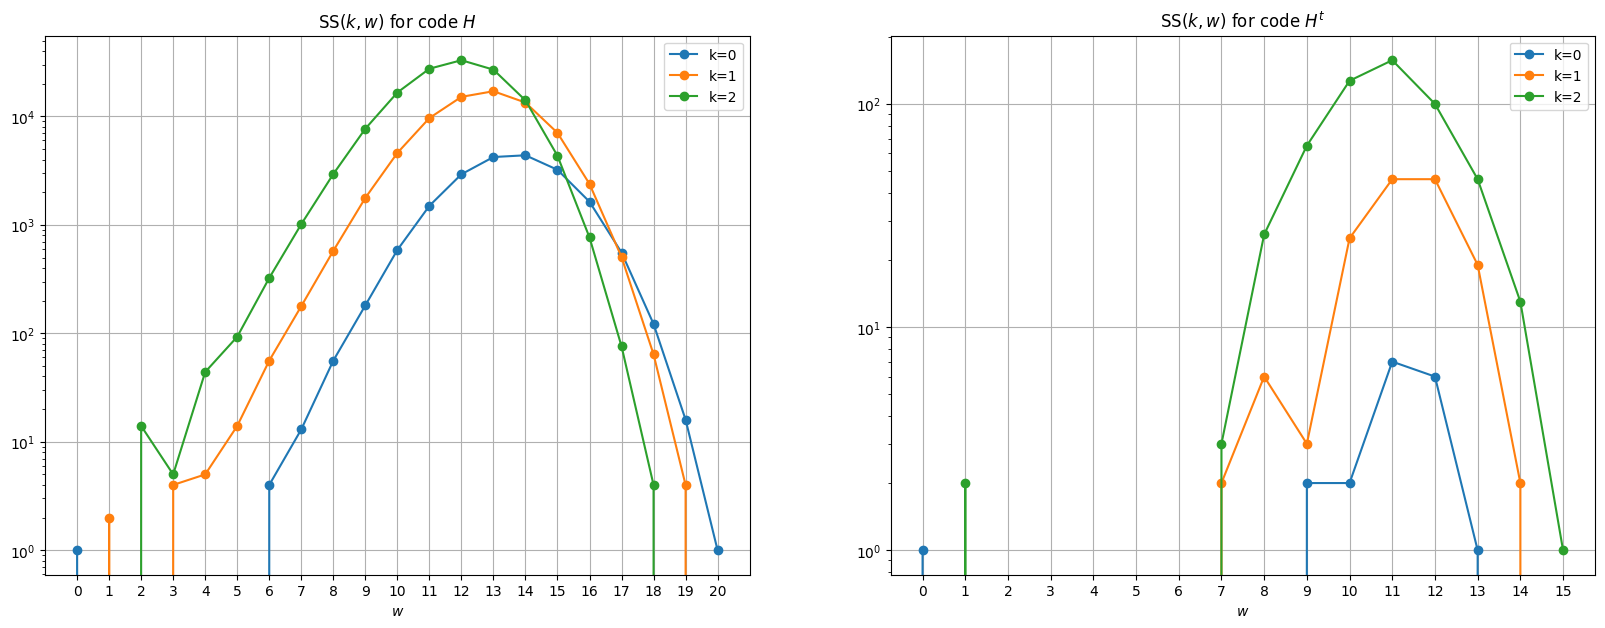

In [113]:
display_SSkxw(H)

In [60]:
def brute_force_peeling_benchmark(H: sp.csr_array) -> np.poly1d:
    m, n  = H.shape
    failure_rate_poly = np.poly1d([0])
    p = np.poly1d([1, 0])
    for i in range(1 << n):
        erasure = np.array(list(np.binary_repr(i, width=n))).astype(np.uint)
        weight = np.count_nonzero(erasure)
        if not peel(erasure, H):
            failure_rate_poly += p**(weight) * (1-p)**(n - weight)

    return np.poly1d(failure_rate_poly)

In [110]:
# failure_rate_poly_H = brute_force_peeling_benchmark(H)
print(failure_rate_poly_H)

      20        19        18        17        16        15        14
-140 x  + 2027 x  - 7220 x  + 9436 x  - 1566 x  - 5825 x  + 1910 x 
         13       12       11      10      9      8     7     6
 + 2712 x  - 760 x  - 683 x  - 14 x  + 68 x + 43 x + 9 x + 4 x


In [173]:
failure_rate_poly_H743 = brute_force_peeling_benchmark(H_7_4_3)
failure_rate_poly_H743

poly1d([-10,  30, -24,  -5,  10,   0,   0,   0])

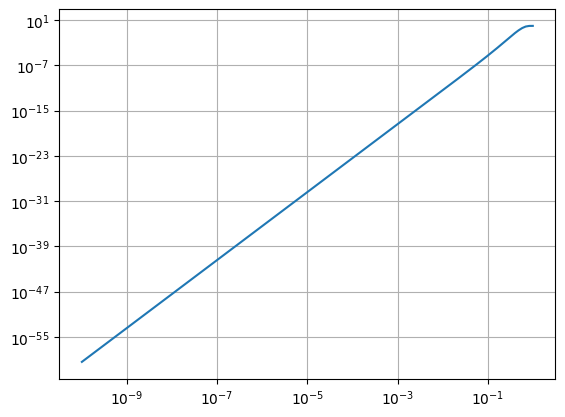

In [111]:
e_p = np.logspace(-10, 0., 128)
p_l = np.polyval(failure_rate_poly_H, e_p)

plt.loglog(e_p, p_l)
plt.grid('minor')
plt.show()

# plt.figure()
# plt.loglog(e_p, np.log(p_l)/np.log(e_p))
# plt.show()

# Load the relevant codes for comparison

- load the PEG code from Connolly's paper
- load the best corresponding code found during the internship
- sample a random code from an LDPC ensemble

In [151]:
def load_tanner_graph(filename, output='H'):
    m, n = np.loadtxt(filename, max_rows=1, dtype=np.uint)
    indices, indptr = np.array([], dtype=np.uint), [0]
    for r in range(m):
        r_ind = np.loadtxt(filename, skiprows=r+1, max_rows=1, dtype=np.uint)
        indices = np.concatenate([indices, np.sort(r_ind)])
        indptr.append(len(r_ind))
    
    H = sp.csr_array((m, n), dtype=np.uint)
    H.data = np.ones_like(indices, dtype=np.uint)
    H.indices = indices
    H.indptr = np.cumsum(indptr)

    out = {'H': H, 'tanner': bpt.from_biadjacency_matrix(H, create_using=nx.MultiGraph)}
    return out[output]

codes = ['[625,25]', '[1225,65]', '[1600,64]', '[2025,81]']
textfiles = ["../initial_codes/"+f"HGP_(3,4)_{code}.txt" for code in codes]

PEG_codes = {code: load_tanner_graph(txtfile) for code, txtfile in zip(codes, textfiles)}

In [171]:
PEG_codes

{'[625,25]': <Compressed Sparse Row sparse array of dtype 'uint64'
 	with 60 stored elements and shape (15, 20)>,
 '[1225,65]': <Compressed Sparse Row sparse array of dtype 'uint64'
 	with 84 stored elements and shape (21, 28)>,
 '[1600,64]': <Compressed Sparse Row sparse array of dtype 'uint64'
 	with 96 stored elements and shape (24, 32)>,
 '[2025,81]': <Compressed Sparse Row sparse array of dtype 'uint64'
 	with 108 stored elements and shape (27, 36)>}

In [170]:
import h5py
from experiments_settings import from_edgelist

best_from_sadl_data = {}

with h5py.File('best_from_sadl.hdf5', 'r') as f:
    for code, grp in f.items():
        best_from_sadl_data[code] = {}
        for beta, subgrp in grp.items():
            best_from_sadl_data[code][beta] = {}
            best_from_sadl_data[code][beta]['theta'] = subgrp['theta'][()].copy()
            best_from_sadl_data[code][beta]['mean'] = subgrp['mean'][()].copy()
            best_from_sadl_data[code][beta]['std'] = subgrp['std'][()].copy()

best_betas = [4, 10, 10, 1]

def tanner_graph_to_H(G: nx.MultiGraph) -> sp.csr_array:
    c, v = bpt.sets(G)
    return bpt.biadjacency_matrix(G, row_order=c, column_order=v).astype(np.uint)

SA_codes = {code: tanner_graph_to_H(from_edgelist(best_from_sadl_data[code][f'beta={beta}']['theta']))
              for code, beta in zip(codes, best_betas)}

SA_codes = {code: SA_codes[code].astype(bool).astype(np.uint)
              for code in codes}

BEST_codes = SA_codes

In [168]:
SA_codes

{'[625,25]': <Compressed Sparse Row sparse array of dtype 'uint64'
 	with 56 stored elements and shape (15, 20)>,
 '[1225,65]': <Compressed Sparse Row sparse array of dtype 'uint64'
 	with 82 stored elements and shape (21, 28)>,
 '[1600,64]': <Compressed Sparse Row sparse array of dtype 'uint64'
 	with 94 stored elements and shape (24, 32)>,
 '[2025,81]': <Compressed Sparse Row sparse array of dtype 'uint64'
 	with 107 stored elements and shape (27, 36)>}

In [166]:
import h5py
from experiments_settings import from_edgelist

best_from_ps_data = {}

with h5py.File('best_from_ps.hdf5', 'r') as f:
    for code, grp in f.items():
        best_from_ps_data[code] = {}
        best_from_ps_data[code]['states'] = grp['states'][()].copy()
        # best_from_ps_data[code]['mean'] = grp['mean'][()].copy()
        # best_from_ps_data[code]['std'] = grp['std'][()].copy()

PS_codes = {code: tanner_graph_to_H(from_edgelist(best_from_ps_data[code]['states']))
              for code in codes}

PS_codes = {code: PS_codes[code].astype(bool).astype(np.uint)
              for code in codes}

In [167]:
PS_codes

{'[625,25]': <Compressed Sparse Row sparse array of dtype 'uint64'
 	with 57 stored elements and shape (15, 20)>,
 '[1225,65]': <Compressed Sparse Row sparse array of dtype 'uint64'
 	with 83 stored elements and shape (21, 28)>,
 '[1600,64]': <Compressed Sparse Row sparse array of dtype 'uint64'
 	with 94 stored elements and shape (24, 32)>,
 '[2025,81]': <Compressed Sparse Row sparse array of dtype 'uint64'
 	with 108 stored elements and shape (27, 36)>}

In [72]:
def polys_from_H(H: sp.csr_array) -> tuple[np.poly1d, np.poly1d]:
    return np.poly1d(np.bincount(np.sum(H, axis=0).astype(int))[::-1]), np.poly1d(np.bincount(np.sum(H, axis=1).astype(int))[::-1])

In [73]:
Lbda_PEG, P_PEG = polys_from_H(PEG_codes['[625,25]'])
print(Lbda_PEG)
print()
print(P_PEG)

print()
print()

Lbda_BEST, P_BEST = polys_from_H(BEST_codes['[625,25]'])
print(Lbda_BEST)
print()
print(P_BEST)

    3
20 x

   5      4     3
1 x + 13 x + 1 x


    3     2
16 x + 4 x

    4     3
11 x + 4 x


In [74]:
# random_code = sample_LDPC(Lbda_PEG, P_PEG)
random_code = H

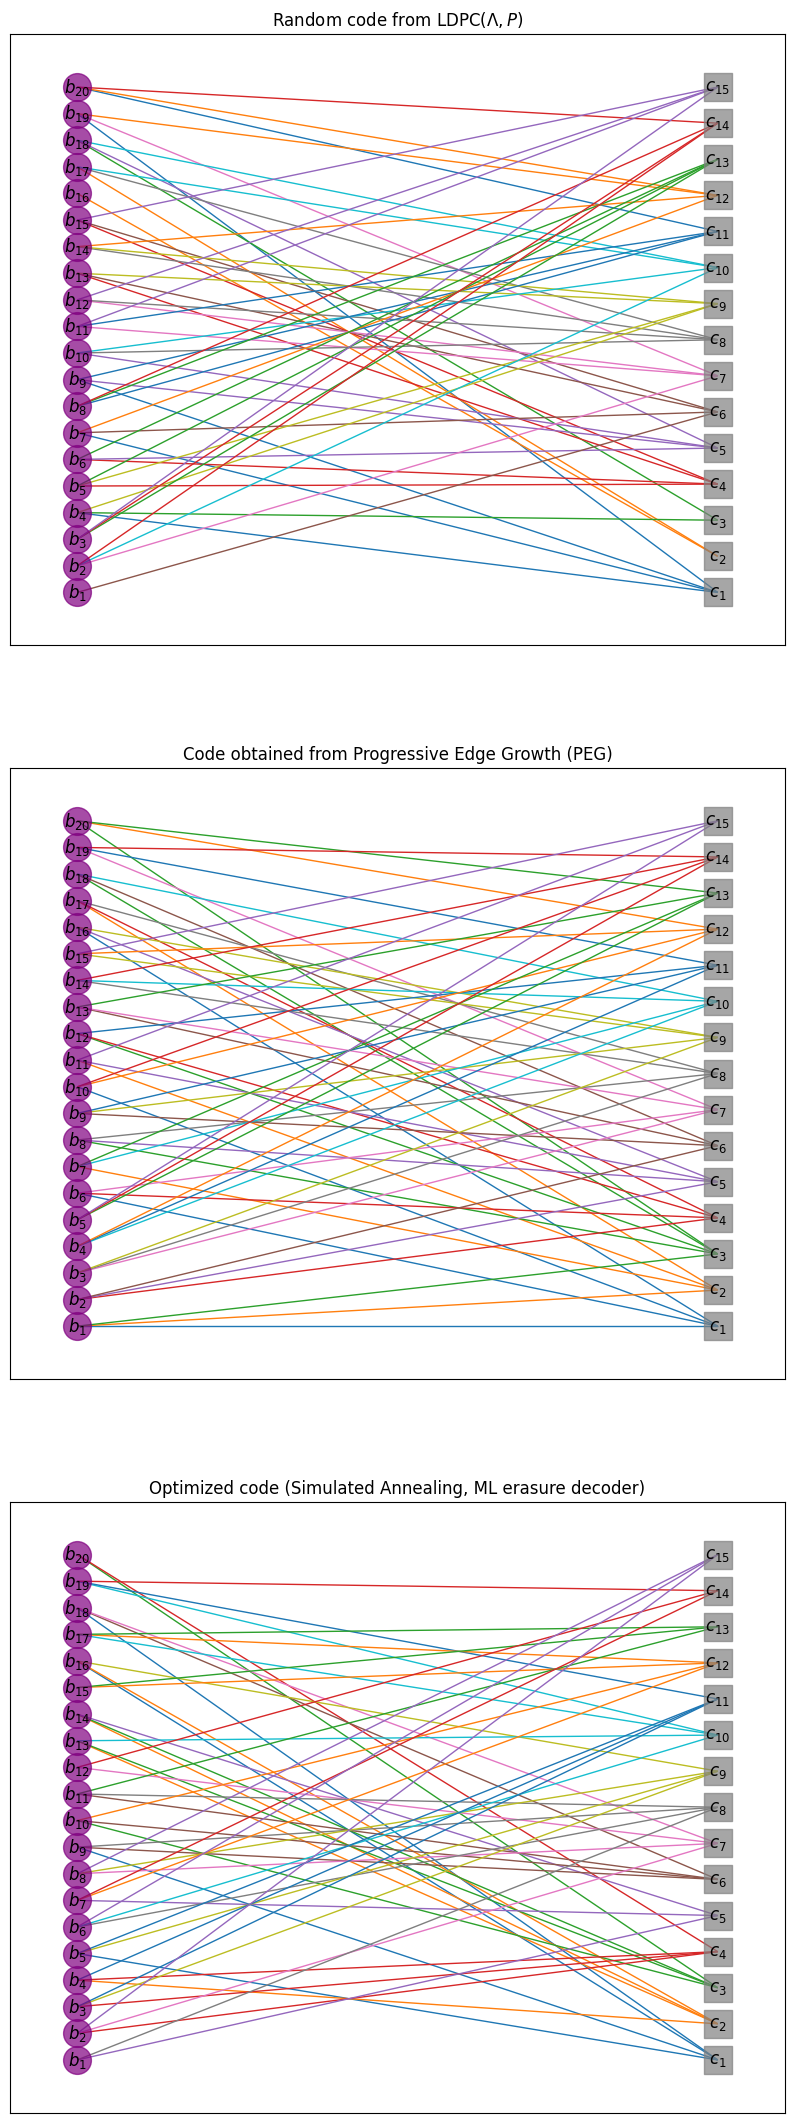

In [90]:
fig, (ax_rand, ax_PEG, ax_BEST) = plt.subplots(3, 1, figsize=(10,27))
ax_rand.set_title(r'Random code from $\mathrm{LDPC}(\Lambda, P)$')
draw_bpt_graph(bpt.from_biadjacency_matrix(random_code), ax=ax_rand)
ax_PEG.set_title(r'Code obtained from Progressive Edge Growth (PEG)')
draw_bpt_graph(bpt.from_biadjacency_matrix(PEG_codes['[625,25]']), ax=ax_PEG)
ax_BEST.set_title(r'Optimized code (Simulated Annealing, ML erasure decoder)')
draw_bpt_graph(bpt.from_biadjacency_matrix(BEST_codes['[625,25]']), ax=ax_BEST)

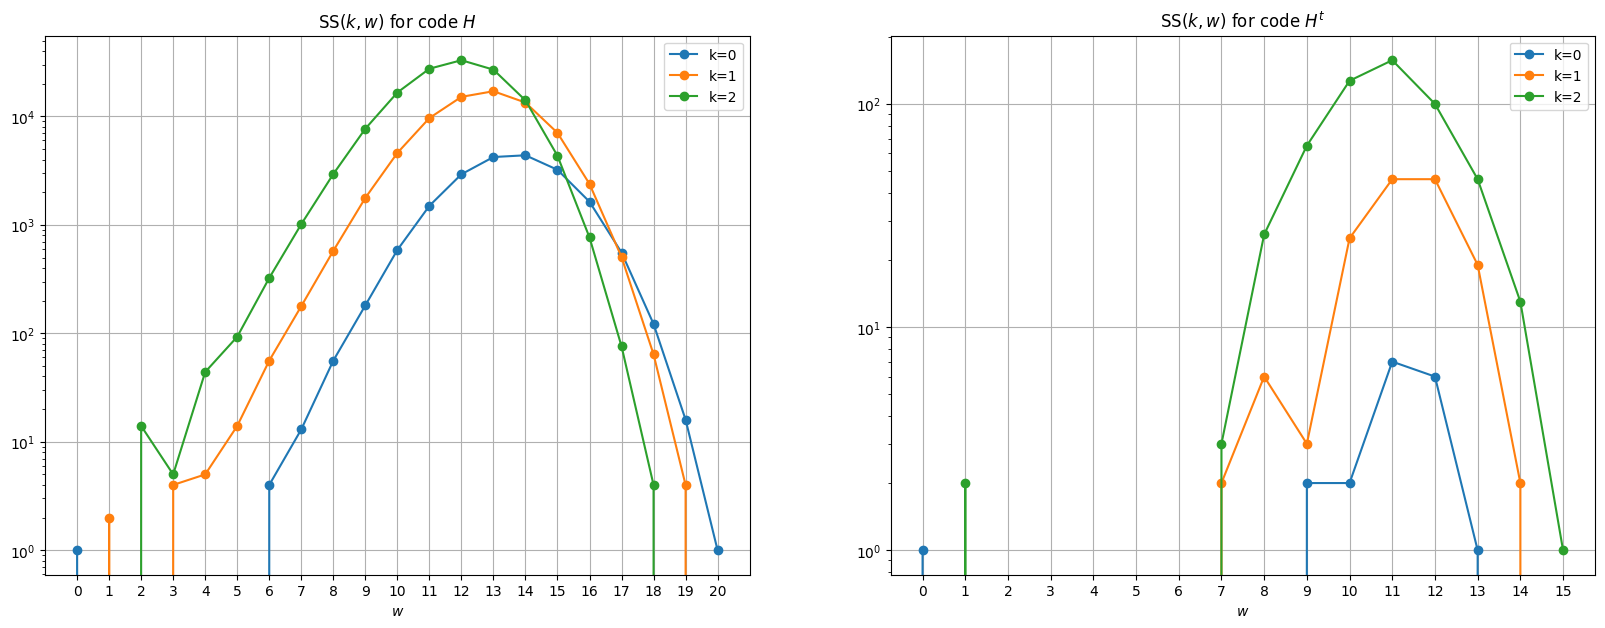

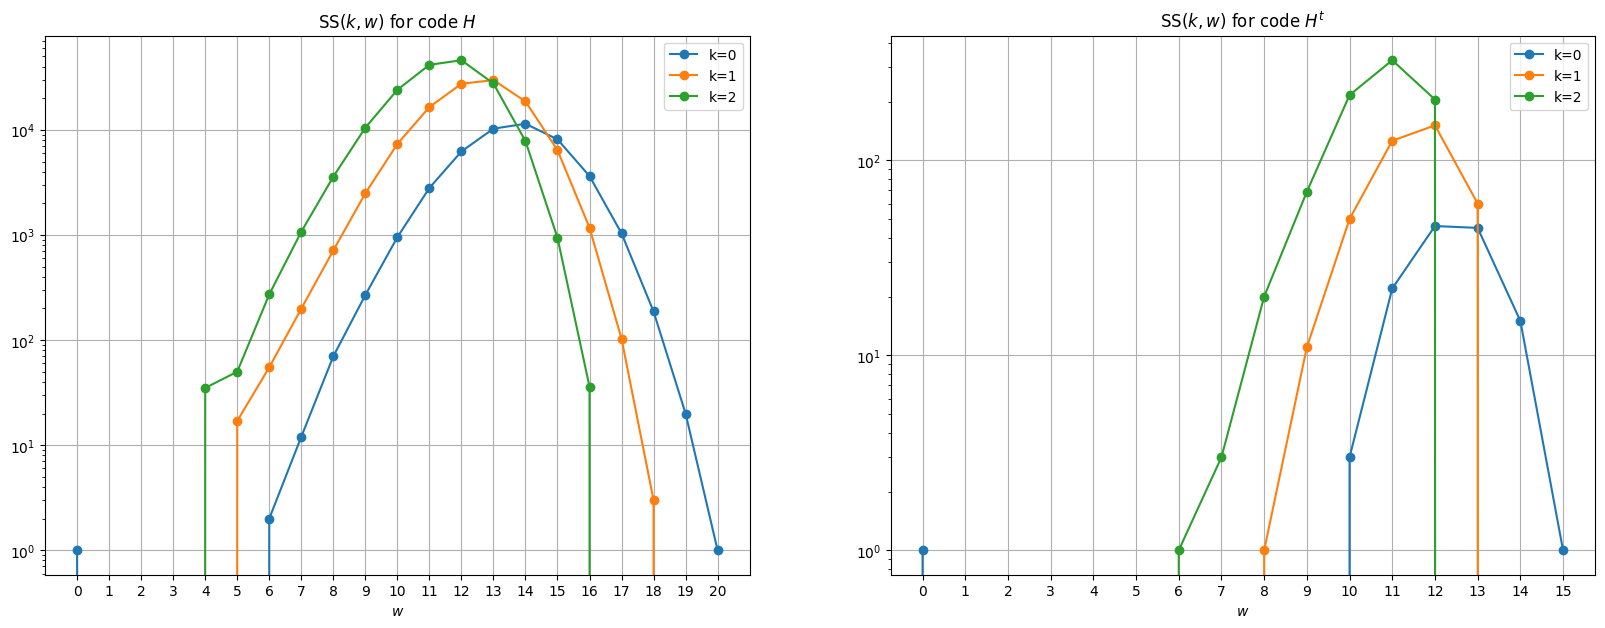

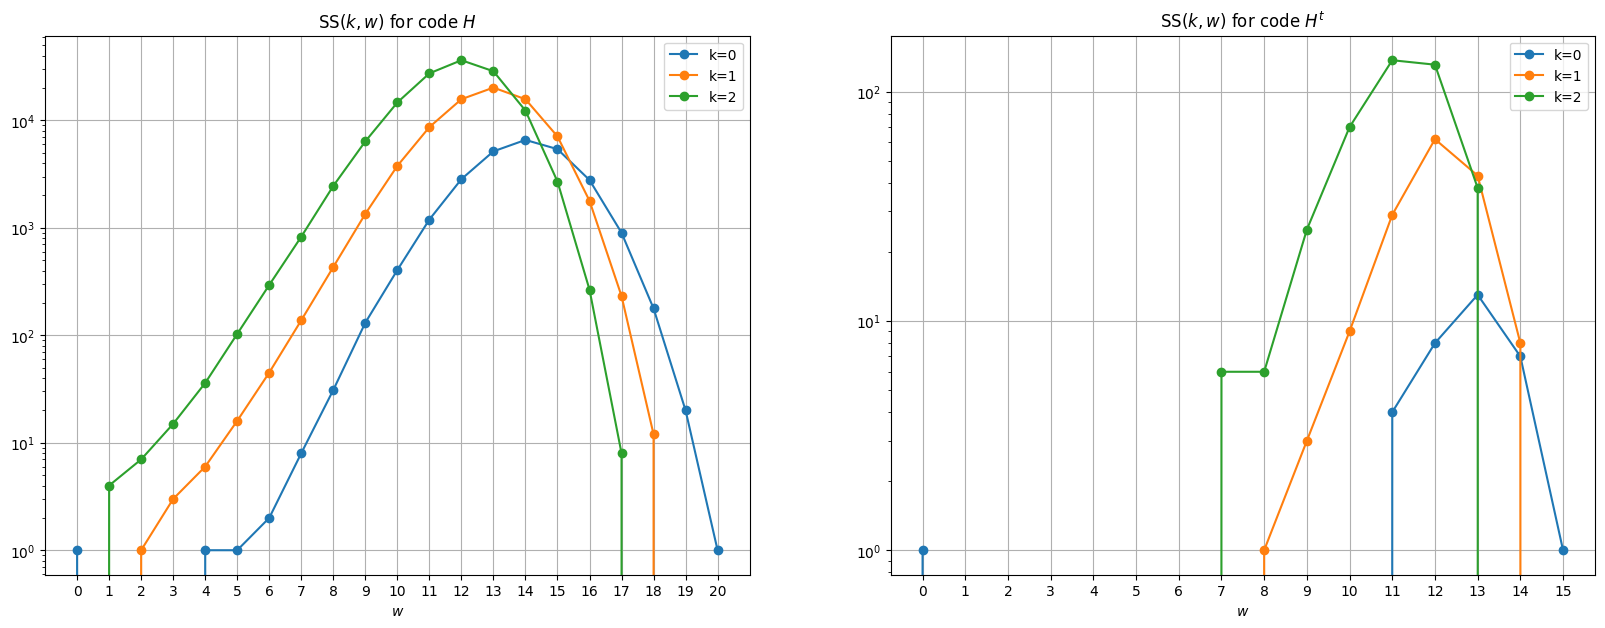

In [241]:
display_SSkxw(random_code)
display_SSkxw(PEG_codes['[625,25]'])
display_SSkxw(BEST_codes['[625,25]'])

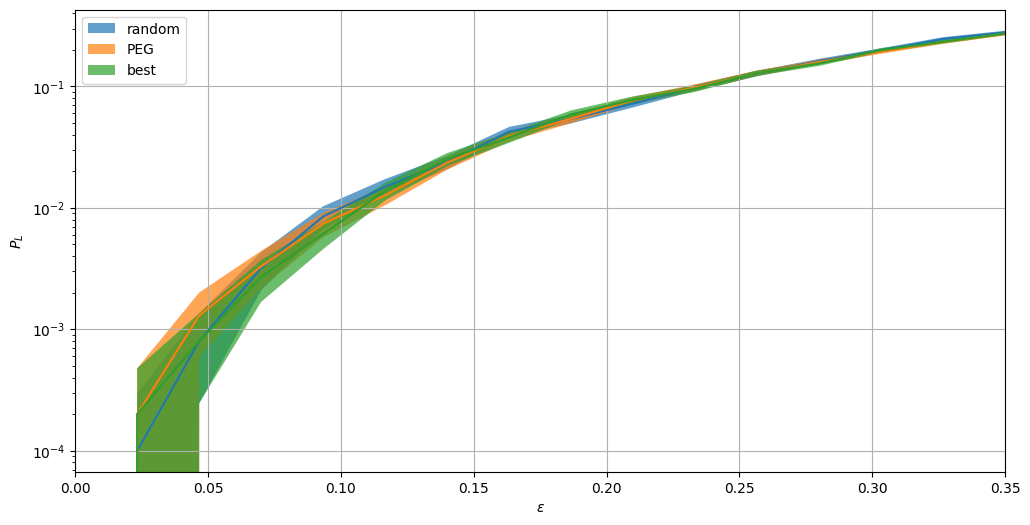

In [109]:
MC_budget = int(1e4)
erasure_rates = np.linspace(0., 0.35, 16)

fig, ax = plt.subplots(1, 1, figsize=(12,6))

peeling_MC_BM_plot([random_code, PEG_codes['[625,25]'], BEST_codes['[625,25]']], erasure_rates, MC_budget, ax=ax, labels=['random', 'PEG', 'best'])

# TODO:
- compute the polynomials for a few selected codes AND THEIR TRANSPOSE!!
- compute the expected $E[SS(0, w=4, 5, 6)]$ and compare to see if it's useful
- run peeling on the induced HGP
- compare the polynomials to the SS(k, w) plots
- research on expurgation algorithms
- https://arxiv.org/pdf/1705.05996
- run simulations on simulated annealing for the peeling cost function and unilateral rewiring action

# Quantum Peeling decoder

In [228]:
def HGP_peel_from_classical(erasure: np.array, H1: sp.csr_array, H2: sp.csr_array=None, both_codes=False, 
                            show_ss=False, store_ss=False, viz=False, ax=None) -> tuple[bool, np.array]:
    if H2 is None:
        H2 = H1
    Hx, Hz = HGP(H1, H2)
    peel_X = peel(erasure.copy(), Hz, show_ss, store_ss, viz, ax=ax)
    
    if both_codes:
        peel_Z = peel(erasure.copy(), Hx, show_ss, store_ss, viz, ax=ax)

        if show_ss or store_ss:
            SS = (peel_X[1], peel_Z[1])
            return (peel_X[0] and peel_Z[0]), SS
        
        return peel_X and peel_Z
    else:
        return peel_X

In [221]:
np.eye(5)[:-1,:]+np.roll(np.eye(5), shift=1, axis=1)[:-1, :]

array([[1., 1., 0., 0., 0.],
       [0., 1., 1., 0., 0.],
       [0., 0., 1., 1., 0.],
       [0., 0., 0., 1., 1.]])

[ True  True  True  True  True False  True  True  True  True False  True
 False  True  True  True  True  True False  True  True  True False]


False

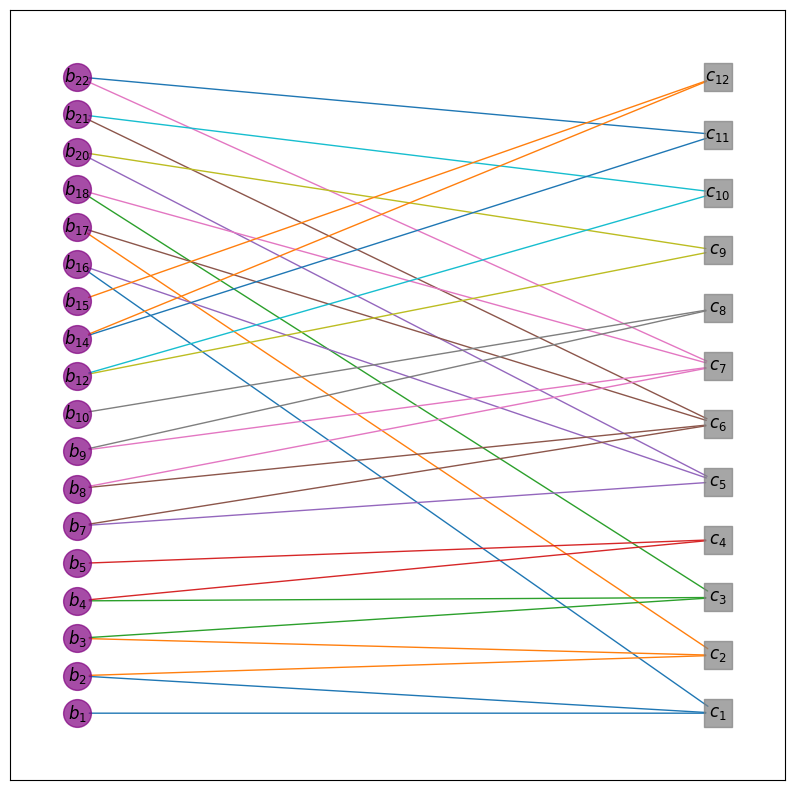

In [239]:
Hrep3 = sp.csr_array(np.eye(3)[:-1,:]+np.roll(np.eye(3), shift=1, axis=1)[:-1, :])
Hrep5 = sp.csr_array(np.eye(5)[:-1,:]+np.roll(np.eye(5), shift=1, axis=1)[:-1, :])

(m1, n1), (m2, n2) = Hrep3.shape, Hrep5.shape
N = n1*n2 + m1*m2
erasure = npr.rand(N) < 0.7
fig, ax = plt.subplots(1, 1, figsize=(10,10))
HGP_peel_from_classical(erasure, Hrep3, Hrep5, viz=True, ax=ax)

In [240]:
print(erasure[:n1*n2].reshape((n1, n2)).astype(int))
print(erasure[n1*n2:].reshape((m1, m2)).astype(int))

[[1 1 1 1 1]
 [0 1 1 1 1]
 [0 1 0 1 1]]
[[1 1 1 0]
 [1 1 1 0]]


# BP+OSD experiments

## Refactor quantum gizmos code

In [201]:
def row_echelon(matrix, full=False):
    """
    Converts a binary matrix to row echelon form via Gaussian Elimination

    Parameters
    ----------
    matrix : numpy.ndarray or scipy.sparse
        A binary matrix in either numpy.ndarray format or scipy.sparse
    full: bool, optional
        If set to 'True', Gaussian elimination is only performed on the rows below
        the pivot. If set to 'False' Gaussian eliminatin is performed on rows above
        and below the pivot. 
    
    Returns
    -------
        row_ech_form: numpy.ndarray
            The row echelon form of input matrix
        rank: int
            The rank of the matrix
        transform_matrix: numpy.ndarray
            The transformation matrix such that (transform_matrix@matrix)=row_ech_form
        pivot_cols: list
            List of the indices of pivot num_cols found during Gaussian elimination

    Examples
    --------
    >>> H=np.array([[1, 1, 1],[1, 1, 1],[0, 1, 0]])
    >>> re_matrix=row_echelon(H)[0]
    >>> print(re_matrix)
    [[1 1 1]
     [0 1 0]
     [0 0 0]]

    >>> re_matrix=row_echelon(H,full=True)[0]
    >>> print(re_matrix)
    [[1 0 1]
     [0 1 0]
     [0 0 0]]

    """
    num_rows, num_cols = np.shape(matrix)

    # Take copy of matrix if numpy (why?) and initialise transform matrix to identity
    if isinstance(matrix, np.ndarray):
        the_matrix = np.copy(matrix)
        transform_matrix = np.identity(num_rows).astype(int)
    elif isinstance(matrix, scipy.sparse.csr.csr_matrix):
        the_matrix = matrix
        transform_matrix = scipy.sparse.eye(num_rows, dtype="int", format="csr")
    else:
        raise ValueError('Unrecognised matrix type')

    pivot_row = 0
    pivot_cols = []

    # Iterate over cols, for each col find a pivot (if it exists)
    for col in range(num_cols):

        # Select the pivot - if not in this row, swap rows to bring a 1 to this row, if possible
        if the_matrix[pivot_row, col] != 1:

            # Find a row with a 1 in this col
            swap_row_index = pivot_row + np.argmax(the_matrix[pivot_row:num_rows, col])

            # If an appropriate row is found, swap it with the pivot. Otherwise, all zeroes - will loop to next col
            if the_matrix[swap_row_index, col] == 1:

                # Swap rows
                the_matrix[[swap_row_index, pivot_row]] = the_matrix[[pivot_row, swap_row_index]]

                # Transformation matrix update to reflect this row swap
                transform_matrix[[swap_row_index, pivot_row]] = transform_matrix[[pivot_row, swap_row_index]]

        # If we have got a pivot, now let's ensure values below that pivot are zeros
        if the_matrix[pivot_row, col]:

            if not full:  
                elimination_range = [k for k in range(pivot_row + 1, num_rows)]
            else:
                elimination_range = [k for k in range(num_rows) if k != pivot_row]

            # Let's zero those values below the pivot by adding our current row to their row
            for j in elimination_range:

                if the_matrix[j, col] != 0 and pivot_row != j:    ### Do we need second condition?

                    the_matrix[j] = (the_matrix[j] + the_matrix[pivot_row]) % 2

                    # Update transformation matrix to reflect this op
                    transform_matrix[j] = (transform_matrix[j] + transform_matrix[pivot_row]) % 2

            pivot_row += 1
            pivot_cols.append(col)

        # Exit loop once there are no more rows to search
        if pivot_row >= num_rows:
            break

    # The rank is equal to the maximum pivot index
    matrix_rank = pivot_row
    row_esch_matrix = the_matrix

    return [row_esch_matrix, matrix_rank, transform_matrix, pivot_cols]

In [202]:
import numpy as np
from ldpc import mod2
from ldpc.alist import save_alist
from ldpc.code_util import compute_code_distance
from bposd import stab

class css_code():

    def __init__(self,hx=np.array([[]]),hz=np.array([[]]),code_distance=np.nan, name="<Unnamed CSS code>"):

        self.hx=hx #hx pcm
        self.hz=hz #hz pcm

        self.lx=np.array([[]]) #x logicals
        self.lz=np.array([[]]) #z logicals

        self.N=np.nan #block length
        self.K=np.nan #code dimension
        self.D=code_distance #code distance
        self.L=np.nan #max column weight
        self.Q=np.nan #max row weight

        _,nx=self.hx.shape
        _,nz=self.hz.shape
        try:
            assert nx==nz
        except AssertionError:
            raise Exception("Error: hx and hz matrices must have equal numbers of columns!")

        if nx!=0:
            self.compute_dimension()
            self.compute_ldpc_params()
            self.compute_logicals()
            if code_distance==0:
                dx=compute_code_distance(hx)
                dz=compute_code_distance(hz)
                self.D=np.min([dx,dz])
                




        self.name=name

    def compute_dimension(self):

        self.N=self.hx.shape[1]
        assert self.N == self.hz.shape[1], "Code block length (N) inconsistent!"

        self.K=self.N-mod2.rank(self.hx)-mod2.rank(self.hz)
        return self.K

    def compute_ldpc_params(self):

        #column weights
        hx_l=np.max(np.sum(self.hx,axis=0))
        hz_l=np.max(np.sum(self.hz,axis=0))
        self.L=np.max([hx_l,hz_l]).astype(int)

        #row weights
        hx_q=np.max(np.sum(self.hx,axis=1))
        hz_q=np.max(np.sum(self.hz,axis=1))
        self.Q=np.max([hx_q,hz_q]).astype(int)

    def save_sparse(self, code_name):

        self.code_name=code_name

        hx=self.hx
        hz=self.hz
        save_alist(f"{code_name}_hx.alist",hx)
        save_alist(f"{code_name}_hz.alist",hz)

        lx=self.lx
        lz=self.lz
        save_alist(f"{code_name}_lx.alist",lx)
        save_alist(f"{code_name}_lz.alist",lz)

    def to_stab_code(self):

        hx=np.vstack([np.zeros(self.hz.shape,dtype=int),self.hx])
        hz=np.vstack([self.hz,np.zeros(self.hx.shape,dtype=int)])
        return stab.stab_code(hx,hz)

    @property
    def h(self):
        hx=np.vstack([np.zeros(self.hz.shape,dtype=int),self.hx])
        hz=np.vstack([self.hz,np.zeros(self.hx.shape,dtype=int)])
        return np.hstack([hx,hz])

    @property
    def l(self):
        lx=np.vstack([np.zeros(self.lz.shape,dtype=int),self.lx])
        lz=np.vstack([self.lz,np.zeros(self.lx.shape,dtype=int)])
        return np.hstack([lx,lz])


    def compute_code_distance(self):
        temp=self.to_stab_code()
        self.D=temp.compute_code_distance()
        return self.D

    def compute_logicals(self):

        def compute_lz(hx,hz):
            #lz logical operators
            #lz\in ker{hx} AND \notin Im(Hz.T)

            ker_hx=mod2.nullspace(hx) #compute the kernel basis of hx
            im_hzT=mod2.row_basis(hz) #compute the image basis of hz.T

            #in the below we row reduce to find vectors in kx that are not in the image of hz.T.
            log_stack=sp.vstack([im_hzT,ker_hx]).todense()
            
            pivots=row_echelon(log_stack.T)[3]
            log_op_indices=[i for i in range(im_hzT.shape[0],log_stack.shape[0]) if i in pivots]
            log_ops=log_stack[log_op_indices]
            return log_ops

        if self.K==np.nan: self.compute_dimension()
        self.lx=compute_lz(self.hz,self.hx)
        self.lz=compute_lz(self.hx,self.hz)

        return self.lx,self.lz

    def canonical_logicals(self):
        temp=mod2.inverse(self.lx@self.lz.T %2)
        self.lx=temp@self.lx %2


    @property
    def code_params(self):
        try: self.N
        except AttributeError: self.N=np.nan
        try: self.K
        except AttributeError: self.K=np.nan
        try: self.D
        except AttributeError: self.D=np.nan
        try: self.L
        except AttributeError: self.L=np.nan
        try: self.Q
        except AttributeError: self.Q=np.nan

        return f"({self.L},{self.Q})-[[{self.N},{self.K},{self.D}]]"

    def test(self, show_tests=True):
        valid_code=True

        if self.K==np.nan: self.compute_dimension()
        self.compute_ldpc_params()

        code_label=f"{self.code_params}"

        if show_tests: print(f"{self.name}, {code_label}")

        try:
            assert self.N==self.hz.shape[1]==self.lz.shape[1]==self.lx.shape[1]
            assert self.K==self.lz.shape[0]==self.lx.shape[0]
            if show_tests: print(" -Block dimensions: Pass")
        except AssertionError:
            valid_code=False
            print(" -Block dimensions incorrect")

        try:
            assert not (self.hz@self.hx.T %2).any()
            if show_tests: print(" -PCMs commute hz@hx.T==0: Pass")
        except AssertionError:
            valid_code=False
            print(" -PCMs commute hz@hx.T==0: Fail")

        try:
            assert not (self.hx@self.hz.T %2).any()
            if show_tests: print(" -PCMs commute hx@hz.T==0: Pass")
        except AssertionError:
            valid_code=False
            print(" -PCMs commute hx@hz.T==0: Fail")

        # if show_tests and valid_code: print("\t-PCMs commute hx@hz.T == hz@hx.T ==0: Pass")

        try:
            assert not (self.hz@self.lx.T %2).any()
        except AssertionError:
            valid_code=False
            print(r" -lx \in ker{hz} AND lz \in ker{hx}: Fail")


        try:
            assert not (self.hx@self.lz.T %2).any()
            if show_tests: print(r" -lx \in ker{hz} AND lz \in ker{hx}: Pass")
        except AssertionError:
            valid_code=False
            print(r" -lx \in ker{hz} AND lz \in ker{hx}: Fail")


        # if show_tests and valid_code: print("\t-lx \in ker{hz} AND lz \in ker{hx}: Pass")

        try:
            assert mod2.rank(self.lx@self.lz.T %2)==self.K
            if show_tests: print(" -lx and lz anticommute: Pass")
        except AssertionError:
            valid_code=False
            print(" -lx and lz anticommute: Fail")

        # if show_tests and valid_code: print("\t- lx and lz anitcommute: Pass")

        if show_tests and valid_code: print(f" -{self.name} is a valid CSS code w/ params {code_label}")

        return valid_code

In [203]:
import numpy as np
from tqdm import tqdm
import json
import time
import datetime
from bposd import bposd_decoder
# from bposd.css import css_code

class css_decode_sim():

    '''
    A class for simulating BP+OSD decoding of CSS codes

    Note
    ....
    The input parameters can be entered directly or as a dictionary. 

    Parameters
    ----------

    hx: numpy.ndarray
        The hx matrix of the CSS code.
    hz: numpy.ndarray
        The hz matrix of the CSS code.
    error_rate: float
        The physical error rate on each qubit.
    xyz_error_bias: list of ints
        The relative bias for X, Y and Z errors.
    seed: int
        The random number generator seed.
    target_runs: int
        The number of runs you wish to simulate.
    bp_method: string
        The BP method. Choose either: 1) "minimum_sum"; 2) "product_sum".
    ms_scaling_factor: float
        The minimum sum scaling factor (if applicable)
    max_iter: int
        The maximum number of iterations for BP.
    osd_method: string
        The OSD method. Choose from: 1) "osd_cs"; 2) "osd_e"; 3) "osd0".
    channel_update: string
        The channel update method. Choose form: 1) None; 2) "x->z"; 3) "z->x".
    output_file: string
        The output file to write to.
    save_interval: int
        The time in interval (in seconds) between writing to the output file.
    check_code: bool
        Check whether the CSS code is valid.
    tqdm_disable: bool
        Enable/disable the tqdm progress bar. If you are running this script on a HPC
        cluster, it is recommend to disable tqdm.
    run_sim: bool
        If enabled (default), the simulation will start automatically.
    hadamard_rotate: bool
        Toggle Hadamard rotate. ON: 1; OFF; 0
    hadamard_rotate_sector1_length: int
        Specifies the number of qubits in sector 1 for the Hadamard rotation.
    error_bar_precision_cutoff: float
        The simulation will stop after this precision is reached.
    '''

    def __init__(self, hx=None, hz=None, **input_dict):

        # default input values
        default_input = {
            'error_rate': None,
            'xyz_error_bias': [1, 1, 1],
            'target_runs': 100,
            'seed': 0,
            'bp_method': "minimum_sum",
            'ms_scaling_factor': 0.625,
            'max_iter': 0,
            'osd_method': "osd_cs",
            'osd_order': 2,
            'save_interval': 2,
            'output_file': None,
            'check_code': 0,
            'tqdm_disable': 0,
            'run_sim': 1,
            'channel_update': "x->z",
            'hadamard_rotate': 0,
            'hadamard_rotate_sector1_length': 0,
            'error_bar_precision_cutoff': 1e-3
        }

        #apply defaults for keys not passed to the class
        for key in input_dict.keys():
            self.__dict__[key] = input_dict[key]
        for key in default_input.keys():
            if key not in input_dict:
                self.__dict__[key] = default_input[key]

        # output variables
        output_values = {
            "K": None,
            "N": None,
            "start_date": None,
            "runtime": 0.0,
            "runtime_readable": None,
            "run_count": 0,
            "bp_converge_count_x": 0,
            "bp_converge_count_z": 0,
            "bp_success_count": 0,
            "bp_logical_error_rate": 0,
            "bp_logical_error_rate_eb": 0,
            "osd0_success_count": 0,
            "osd0_logical_error_rate": 0.0,
            "osd0_logical_error_rate_eb": 0.0,
            "osdw_success_count": 0,
            "osdw_logical_error_rate": 0.0,
            "osdw_logical_error_rate_eb": 0.0,
            "osdw_word_error_rate": 0.0,
            "osdw_word_error_rate_eb": 0.0,
            "min_logical_weight": 1e9
        }

        for key in output_values.keys(): #copies initial values for output attributes
            if key not in self.__dict__:
                self.__dict__[key] = output_values[key]

        #the attributes we wish to save to file
        temp = [] 
        for key in self.__dict__.keys():
            if key not in ['channel_probs_x','channel_probs_z','channel_probs_y','hx','hz']:
                temp.append(key)
        self.output_keys = temp

        #random number generator setup
        if self.seed==0 or self.run_count!=0:
            self.seed=np.random.randint(low=1,high=2**32-1)
        np.random.seed(self.seed)
        print(f"RNG Seed: {self.seed}")
        
        # the hx and hx matrices
        self.hx = hx.astype(int)
        self.hz = hz.astype(int)
        self.N = self.hz.shape[1] #the block length
        if self.min_logical_weight == 1e9: #the minimum observed weight of a logical operator
            self.min_logical_weight=self.N 
        self.error_x = np.zeros(self.N).astype(int) #x_component error vector
        self.error_z = np.zeros(self.N).astype(int) #z_component error vector

        # construct the CSS code from hx and hz
        self._construct_code()

        # setup the error channel
        self._error_channel_setup()

        # setup the BP+OSD decoders
        self._decoder_setup()

        if self.run_sim:
            self.run_decode_sim()

    def _single_run(self):

        '''
        The main simulation procedure
        '''

        # randomly generate the error
        self.error_x, self.error_z = self._generate_error()

        if self.channel_update is None:
            # decode z
            synd_z = self.hx@self.error_z % 2
            self.bpd_z.decode(synd_z)

            # decode x
            synd_x = self.hz@self.error_x % 2
            self.bpd_x.decode(synd_x)

        elif self.channel_update=="z->x":
            # decode z
            synd_z = self.hx@self.error_z % 2
            self.bpd_z.decode(synd_z)

            #update the channel probability
            self._channel_update(self.channel_update)

            # decode x
            synd_x = self.hz@self.error_x % 2
            self.bpd_x.decode(synd_x)

        elif self.channel_update=="x->z":
            
            # decode x
            synd_x = self.hz@self.error_x % 2
            self.bpd_x.decode(synd_x)
            
            #update the channel probability
            self._channel_update(self.channel_update)

            # decode z
            synd_z = self.hx@self.error_z % 2
            self.bpd_z.decode(synd_z)

        #compute the logical and word error rates
        self._encoded_error_rates()

    def _channel_update(self,update_direction):

        '''
        Function updates the channel probability vector for the second decoding component
        based on the first. The channel probability updates can be derived from Bayes' rule.
        '''

        #x component first, then z component
        if update_direction=="x->z":
            decoder_probs=np.zeros(self.N)
            for i in range(self.N):
                if self.bpd_x.osdw_decoding[i]==1:
                    if (self.channel_probs_x[i]+self.channel_probs_y[i])==0:
                        decoder_probs[i]=0
                    else:
                        decoder_probs[i]=self.channel_probs_y[i]/(self.channel_probs_x[i]+self.channel_probs_y[i])
                elif self.bpd_x.osdw_decoding[i]==0:
                        decoder_probs[i]=self.channel_probs_z[i]/(1-self.channel_probs_x[i]-self.channel_probs_y[i])
        
            self.bpd_z.update_channel_probs(decoder_probs)

        #z component first, then x component
        elif update_direction=="z->x":
            self.bpd_z.osdw_decoding
            decoder_probs=np.zeros(self.N)
            for i in range(self.N):
                if self.bpd_z.osdw_decoding[i]==1:
                    
                    if (self.channel_probs_z[i]+self.channel_probs_y[i])==0:
                        decoder_probs[i]=0
                    else:
                        decoder_probs[i]=self.channel_probs_y[i]/(self.channel_probs_z[i]+self.channel_probs_y[i])
                elif self.bpd_z.osdw_decoding[i]==0:
                        decoder_probs[i]=self.channel_probs_x[i]/(1-self.channel_probs_z[i]-self.channel_probs_y[i])

            
            self.bpd_x.update_channel_probs(decoder_probs)



    def _encoded_error_rates(self):

        '''
        Updates the logical and word error rates for OSDW, OSD0 and BP (before post-processing)
        '''

        #OSDW Logical error rate
        # calculate the residual error
        residual_x = (self.error_x+self.bpd_x.osdw_decoding) % 2
        residual_z = (self.error_z+self.bpd_z.osdw_decoding) % 2

        # check for logical X-error
        if (self.lz@residual_x % 2).any():
            logical_weight = np.sum(residual_x)
            if logical_weight < self.min_logical_weight:
                self.min_logical_weight = int(logical_weight)

        # check for logical Z-error
        elif (self.lx@residual_z % 2).any():
            logical_weight = np.sum(residual_z)
            if logical_weight < self.min_logical_weight:
                self.min_logical_weight = int(logical_weight)
        else:
            self.osdw_success_count += 1

        # compute logical error rate
        self.osdw_logical_error_rate = 1-self.osdw_success_count/self.run_count
        self.osdw_logical_error_rate_eb = np.sqrt(
            (1-self.osdw_logical_error_rate)*self.osdw_logical_error_rate/self.run_count)

        # compute word error rate
        self.osdw_word_error_rate = 1.0 - \
            (1-self.osdw_logical_error_rate)**(1/self.K)
        self.osdw_word_error_rate_eb = self.osdw_logical_error_rate_eb * \
            ((1-self.osdw_logical_error_rate_eb)**(1/self.K - 1))/self.K

        #OSD0 logical error rate
        # calculate the residual error
        residual_x = (self.error_x+self.bpd_x.osd0_decoding) % 2
        residual_z = (self.error_z+self.bpd_z.osd0_decoding) % 2

        # check for logical X-error
        if (self.lz@residual_x % 2).any():
            logical_weight = np.sum(residual_x)
            if logical_weight < self.min_logical_weight:
                self.min_logical_weight = int(logical_weight)

        # check for logical Z-error
        elif (self.lx@residual_z % 2).any():
            logical_weight = np.sum(residual_z)
            if logical_weight < self.min_logical_weight:
                self.min_logical_weight = int(logical_weight)
        else:
            self.osd0_success_count += 1

        # compute logical error rate
        self.osd0_logical_error_rate = 1-self.osd0_success_count/self.run_count
        self.osd0_logical_error_rate_eb = np.sqrt(
            (1-self.osd0_logical_error_rate)*self.osd0_logical_error_rate/self.run_count)

        # compute word error rate
        self.osd0_word_error_rate = 1.0 - \
            (1-self.osd0_logical_error_rate)**(1/self.K)
        self.osd0_word_error_rate_eb = self.osd0_logical_error_rate_eb * \
            ((1-self.osd0_logical_error_rate_eb)**(1/self.K - 1))/self.K

        #BP Logical error rate
        #check for convergence
        if self.bpd_z.converge:
            self.bp_converge_count_z+=1
        if self.bpd_x.converge:
            self.bp_converge_count_x+=1

        if self.bpd_z.converge and self.bpd_x.converge:
            # calculate the residual error
            residual_x = (self.error_x+self.bpd_x.bp_decoding) % 2
            residual_z = (self.error_z+self.bpd_z.bp_decoding) % 2

            # check for logical X-error
            if (self.lz@residual_x % 2).any():
                pass

            # check for logical Z-error
            elif (self.lx@residual_z % 2).any():
                pass
            else:
                self.bp_success_count += 1

        # compute logical error rate
        self.bp_logical_error_rate = 1-self.bp_success_count/self.run_count
        self.bp_logical_error_rate_eb = np.sqrt(
            (1-self.bp_logical_error_rate)*self.bp_logical_error_rate/self.run_count)

        # compute word error rate
        self.bp_word_error_rate = 1.0 - \
            (1-self.bp_logical_error_rate)**(1/self.K)
        self.bp_word_error_rate_eb = self.bp_logical_error_rate_eb * \
            ((1-self.bp_logical_error_rate_eb)**(1/self.K - 1))/self.K

    def _construct_code(self):

        '''
        Constructs the CSS code from the hx and hz stabilizer matrices.
        '''

        # print("Constructing CSS code from hx and hz matrices...")
        if isinstance(self.hx, np.ndarray) and isinstance(self.hz, np.ndarray):
            qcode = css_code(self.hx, self.hz)
            self.lx = qcode.lx
            self.lz = qcode.lz
            self.K = qcode.K
            self.N = qcode.N
            # print("Checking the CSS code is valid...")
            if self.check_code and not qcode.test():
                raise Exception(
                    "Error: invalid CSS code. Check the form of your hx and hz matrices!")
        else:
            raise Exception("Invalid object type for the hx/hz matrices")
        return None

    def _error_channel_setup(self):

        '''
        Sets up the error channels from the error rate and error bias input parameters
        '''

        xyz_error_bias = np.array(self.xyz_error_bias)
        if xyz_error_bias[0] == np.inf:
            self.px = self.error_rate
            self.py = 0
            self.pz = 0
        elif xyz_error_bias[1] == np.inf:
            self.px = 0
            self.py = self.error_rate
            self.pz = 0
        elif xyz_error_bias[2] == np.inf:
            self.px = 0
            self.py = 0
            self.pz = self.error_rate
        else:
            self.px, self.py, self.pz = self.error_rate * \
                xyz_error_bias/np.sum(xyz_error_bias)

        if self.hadamard_rotate==0:
            self.channel_probs_x = np.ones(self.N)*(self.px)
            self.channel_probs_z = np.ones(self.N)*(self.pz)
            self.channel_probs_y = np.ones(self.N)*(self.py)
        
        elif self.hadamard_rotate==1:
            n1=self.hadamard_rotate_sector1_length
            self.channel_probs_x =np.hstack([np.ones(n1)*(self.px),np.ones(self.N-n1)*(self.pz)])
            self.channel_probs_z =np.hstack([np.ones(n1)*(self.pz),np.ones(self.N-n1)*(self.px)])
            self.channel_probs_y = np.ones(self.N)*(self.py)
        else:
            raise ValueError(f"The hadamard rotate attribute should be set to 0 or 1. Not '{self.hadamard_rotate}")

        self.channel_probs_x.setflags(write=False)
        self.channel_probs_y.setflags(write=False)
        self.channel_probs_z.setflags(write=False)


    def _decoder_setup(self):

        '''
        Setup for the BP+OSD decoders 
        '''

        # decoder for Z errors
        self.bpd_z = bposd_decoder(
            self.hx,
            channel_probs=self.channel_probs_z+self.channel_probs_y,
            max_iter=self.max_iter,
            bp_method=self.bp_method,
            ms_scaling_factor=self.ms_scaling_factor,
            osd_method=self.osd_method,
            osd_order=self.osd_order,
        )

        # decoder for X-errors
        self.bpd_x = bposd_decoder(
            self.hz,
            channel_probs=self.channel_probs_x+self.channel_probs_y,
            max_iter=self.max_iter,
            bp_method=self.bp_method,
            ms_scaling_factor=self.ms_scaling_factor,
            osd_method=self.osd_method,
            osd_order=self.osd_order,
        )

    def _generate_error(self):

        '''
        Generates a random error on both the X and Z components of the code
        distributed according to the channel probability vectors.
        '''

        for i in range(self.N):
            rand = np.random.random()
            if rand < self.channel_probs_z[i]:
                self.error_z[i] = 1
                self.error_x[i] = 0
            elif self.channel_probs_z[i] <= rand < (self.channel_probs_z[i]+self.channel_probs_x[i]):
                self.error_z[i] = 0
                self.error_x[i] = 1
            elif (self.channel_probs_z[i]+self.channel_probs_x[i]) <= rand < (self.channel_probs_x[i]+self.channel_probs_y[i]+self.channel_probs_z[i]):
                self.error_z[i] = 1
                self.error_x[i] = 1
            else:
                self.error_z[i] = 0
                self.error_x[i] = 0

        return self.error_x, self.error_z
 
    def run_decode_sim(self):

        '''
        This function contains the main simulation loop and controls the output.
        '''

        # save start date
        self.start_date = datetime.datetime.fromtimestamp(
            time.time()).strftime("%A, %B %d, %Y %H:%M:%S")

        pbar = tqdm(range(self.run_count+1, self.target_runs+1),
                    disable=self.tqdm_disable, ncols=0)

        start_time = time.time()
        save_time = start_time

        for self.run_count in pbar:

            self._single_run()

            pbar.set_description(f"d_max: {self.min_logical_weight}; OSDW_WER: {self.osdw_word_error_rate*100:.3g}±{self.osdw_word_error_rate_eb*100:.2g}%; OSDW: {self.osdw_logical_error_rate*100:.3g}±{self.osdw_logical_error_rate_eb*100:.2g}%; OSD0: {self.osd0_logical_error_rate*100:.3g}±{self.osd0_logical_error_rate_eb*100:.2g}%;")

            current_time = time.time()
            save_loop = current_time-save_time

            if int(save_loop)>self.save_interval or self.run_count==self.target_runs:
                save_time=time.time()
                self.runtime = save_loop +self.runtime

                self.runtime_readable=time.strftime('%H:%M:%S', time.gmtime(self.runtime))


                if self.output_file!=None:
                    f=open(self.output_file,"w+")
                    print(self.output_dict(),file=f)
                    f.close()

                if self.osdw_logical_error_rate_eb>0 and self.osdw_logical_error_rate_eb/self.osdw_logical_error_rate < self.error_bar_precision_cutoff:
                    print("\nTarget error bar precision reached. Stopping simulation...")
                    break

        return json.dumps(self.output_dict(),sort_keys=True, indent=4)

    def output_dict(self):

        '''
        Function for formatting the output
        '''

        output_dict = {}
        for key, value in self.__dict__.items():
            if key in self.output_keys:
                output_dict[key] = value
        # return output_dict
        return output_dict

## Get back to running simulations

In [204]:
Hx, Hz = HGP(PEG_codes[codes[0]])

Hx = Hx.todense()
Hz = Hz.todense()

params = {
    "error_rate": 0.1, #the physical error rate on the qubits
    "target_runs": int(1e3), #the number of cycles to simulate
    'max_iter': int(Hx.shape[1]/10), #the interation depth for BP
    'tqdm_disable': True #show live stats
}
simulation = css_decode_sim(hx=Hx, hz=Hz, **params)

RNG Seed: 2316138465


In [205]:
simulation.output_dict()

{'error_rate': 0.1,
 'target_runs': 1000,
 'max_iter': 62,
 'tqdm_disable': True,
 'xyz_error_bias': [1, 1, 1],
 'seed': 2316138465,
 'bp_method': 'minimum_sum',
 'ms_scaling_factor': 0.625,
 'osd_method': 'osd_cs',
 'osd_order': 2,
 'save_interval': 2,
 'output_file': None,
 'check_code': 0,
 'run_sim': 1,
 'channel_update': 'x->z',
 'hadamard_rotate': 0,
 'hadamard_rotate_sector1_length': 0,
 'error_bar_precision_cutoff': 0.001,
 'K': 25,
 'N': 625,
 'start_date': 'Tuesday, December 17, 2024 15:53:48',
 'runtime': 29.674278736114502,
 'runtime_readable': '00:00:29',
 'run_count': 1000,
 'bp_converge_count_x': 234,
 'bp_converge_count_z': 526,
 'bp_success_count': 154,
 'bp_logical_error_rate': 0.846,
 'bp_logical_error_rate_eb': 0.011414201680362933,
 'osd0_success_count': 481,
 'osd0_logical_error_rate': 0.519,
 'osd0_logical_error_rate_eb': 0.01579996835439869,
 'osdw_success_count': 666,
 'osdw_logical_error_rate': 0.33399999999999996,
 'osdw_logical_error_rate_eb': 0.014914556647

In [45]:
%load_ext autoreload
%autoreload 2

## Prepare BP+OSD simulations for each of the desired codes

In [246]:
filtered_codes = [code for code in codes if code != "[1225,65]"]

In [ ]:
error_rates = np.logspace(-2, -1, 10)

results = {code: {} for code in filtered_codes}
t, t0, dt = time.time(), time.time(), None
for family_name, family_dict in zip(["PEG", "SA", "PS"], [PEG_codes, SA_codes, PS_codes]):
    print(f'{family_name = }')
    for code in filtered_codes:
        print(f'\t{code = }')
        results[code][family_name] = {"ler": [], "ler_eb": []}

        Hx, Hz = HGP(family[code])
        Hx, Hz = Hx.todense(), Hz.todense()

        for er in error_rates:
            print(f'\t\t{er = :.2g}')
            params = {
                "error_rate": er, #the physical error rate on the qubits
                "target_runs": int(1e1), #the number of cycles to simulate
                'max_iter': int(Hx.shape[1]/10), #the interation depth for BP
                'tqdm_disable': True #show live stats
            }
            simulation = css_decode_sim(hx=Hx, hz=Hz, **params).output_dict()
            ler, ler_eb = simulation["osdw_logical_error_rate"], simulation["osdw_logical_error_rate_eb"]
            results[code][family_name]["ler"].append(ler)
            results[code][family_name]["ler_eb"].append(ler_eb)
            dt = time.time() - t
            print(f'elapsed: {dt:.6f} s | total: {dt+t-t0:.6f} s')
            t += dt
        

In [229]:
# results

In [249]:
import pickle

names = ["PEG_codes", "SA_codes", "PS_codes"]
objs = []
for name, obj in zip(names, [PEG_codes, SA_codes, PS_codes]):
    with open(name+'.pkl', 'wb') as f:
        pickle.dump(obj, f)
    # with open(name+'.pkl', 'rb') as f:
    #     objs.append(pickle.load(f))

In [245]:
objs[2]

{'[625,25]': <Compressed Sparse Row sparse array of dtype 'uint64'
 	with 57 stored elements and shape (15, 20)>,
 '[1225,65]': <Compressed Sparse Row sparse array of dtype 'uint64'
 	with 83 stored elements and shape (21, 28)>,
 '[1600,64]': <Compressed Sparse Row sparse array of dtype 'uint64'
 	with 94 stored elements and shape (24, 32)>,
 '[2025,81]': <Compressed Sparse Row sparse array of dtype 'uint64'
 	with 108 stored elements and shape (27, 36)>}

## Visualizing results

In [238]:
np.logspace(-2,-1,10)

array([0.01      , 0.0129155 , 0.01668101, 0.02154435, 0.02782559,
       0.03593814, 0.04641589, 0.05994843, 0.07742637, 0.1       ])

In [239]:
import h5py

results = {}
with h5py.File("bposd_simulations.hdf5", "r") as f: 
    for family, grp in f.items():
        print(family)
        for code, subgrp in grp.items():
            print(code)
            print([subsubgrp for subsubgrp in subgrp.keys()])
            safe_div = np.vectorize(lambda a,b: a/b if b > 0 else 0)
            print(safe_div(np.concatenate([subsubgrp["ler_eb"][()] for subsubgrp in subgrp.values()]), 
                           np.concatenate([subsubgrp["ler"][()] for subsubgrp in subgrp.values()])
                          )
                 )

PEG_codes
[1225,65]
['ER=0', 'ER=1', 'ER=2', 'ER=3', 'ER=4', 'ER=5', 'ER=6', 'ER=7', 'ER=8', 'ER=9']
[0.70639932 0.         0.         0.57648359 0.4070217  0.33182994
 0.22722583 0.12744167 0.06962724 0.03271687]
[1600,64]
['ER=0', 'ER=1', 'ER=2', 'ER=3', 'ER=4', 'ER=5', 'ER=6', 'ER=7', 'ER=8', 'ER=9']
[0 0 0 0 0 0 0 0 0 0]
[625,25]
['ER=0', 'ER=1', 'ER=2', 'ER=3', 'ER=4', 'ER=5', 'ER=6', 'ER=7', 'ER=8', 'ER=9']
[0.1863177  0.29984845 0.99949987 0.70639932 0.99949987 0.4070217
 0.23357131 0.17392527 0.09135532 0.04415713]
PS_codes
[1225,65]
['ER=0', 'ER=1', 'ER=2', 'ER=3', 'ER=4', 'ER=5', 'ER=6', 'ER=7', 'ER=8', 'ER=9']
[0.99949987 0.         0.         0.         0.         0.99949987
 0.57648359 0.31464265 0.12628995 0.04328468]
[1600,64]
['ER=0', 'ER=1', 'ER=2', 'ER=3', 'ER=4', 'ER=5', 'ER=6', 'ER=7', 'ER=8', 'ER=9']
[0 0 0 0 0 0 0 0 0 0]
[625,25]
['ER=0', 'ER=1', 'ER=2', 'ER=3', 'ER=4', 'ER=5', 'ER=6', 'ER=7', 'ER=8', 'ER=9']
[0.21591445 0.33182994 0.         0.         0.99949987